# Classification Multi-Label de Commentaires Toxiques

Ce notebook adapte les techniques de classification de texte pour prédire 6 labels de toxicité simultanément:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Approche: Classification multi-label avec 6 classificateurs binaires indépendants.

## 1. Imports et Configuration

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# NLP preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    f1_score,
    hamming_loss,
    jaccard_score,
    roc_auc_score
)

import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Random seed pour la reproductibilité
RANDOM_STATE = 42

## 2. Téléchargement des ressources NLTK

In [95]:
# Télécharger les ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 3. Chargement des Données

In [96]:
# Charger le dataset
df = pd.read_csv('train.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nPremières lignes:")
df.head()

Dataset shape: (159571, 8)

Premières lignes:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [97]:
# Informations sur le dataset
print("Informations sur le dataset:")
df.info()

print("\nValeurs manquantes:")
print(df.isnull().sum())

print("\nStatistiques descriptives:")
df.describe()

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

Valeurs manquantes:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Statistiques descriptives:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Analyse Exploratoire des Données (EDA)

In [98]:
# Labels disponibles
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("Distribution des labels:")
print(df[label_cols].sum())
print(f"\nTotal commentaires: {len(df)}")
print(f"Commentaires toxiques (au moins 1 label): {(df[label_cols].sum(axis=1) > 0).sum()}")
print(f"Commentaires non-toxiques: {(df[label_cols].sum(axis=1) == 0).sum()}")

Distribution des labels:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Total commentaires: 159571
Commentaires toxiques (au moins 1 label): 16225
Commentaires non-toxiques: 143346


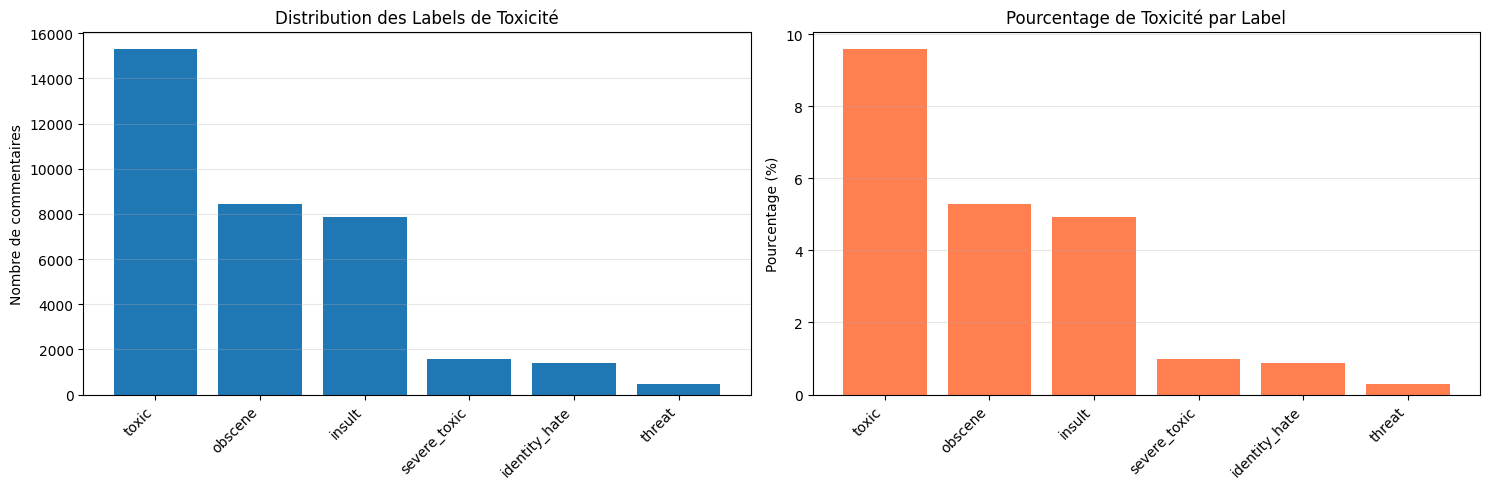

In [99]:
# Visualisation de la distribution des labels
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des labels
label_counts = df[label_cols].sum().sort_values(ascending=False)
axes[0].bar(range(len(label_counts)), label_counts.values)
axes[0].set_xticks(range(len(label_counts)))
axes[0].set_xticklabels(label_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Nombre de commentaires')
axes[0].set_title('Distribution des Labels de Toxicité')
axes[0].grid(axis='y', alpha=0.3)

# Pourcentage
label_pct = (df[label_cols].sum() / len(df) * 100).sort_values(ascending=False)
axes[1].bar(range(len(label_pct)), label_pct.values, color='coral')
axes[1].set_xticks(range(len(label_pct)))
axes[1].set_xticklabels(label_pct.index, rotation=45, ha='right')
axes[1].set_ylabel('Pourcentage (%)')
axes[1].set_title('Pourcentage de Toxicité par Label')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

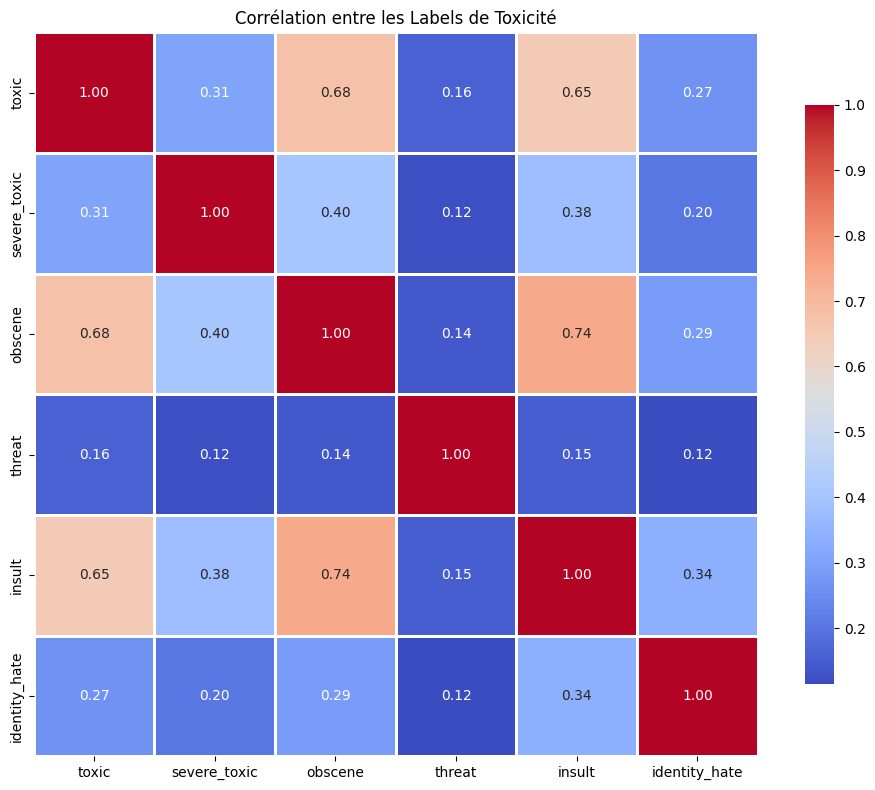


Interprétation:
- Une forte corrélation indique que ces labels apparaissent souvent ensemble
- Valeurs proches de 1: forte corrélation positive
- Valeurs proches de 0: peu de corrélation


In [100]:
# Matrice de corrélation entre labels
plt.figure(figsize=(10, 8))
correlation_matrix = df[label_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Corrélation entre les Labels de Toxicité')
plt.tight_layout()
plt.show()

print("\nInterprétation:")
print("- Une forte corrélation indique que ces labels apparaissent souvent ensemble")
print("- Valeurs proches de 1: forte corrélation positive")
print("- Valeurs proches de 0: peu de corrélation")

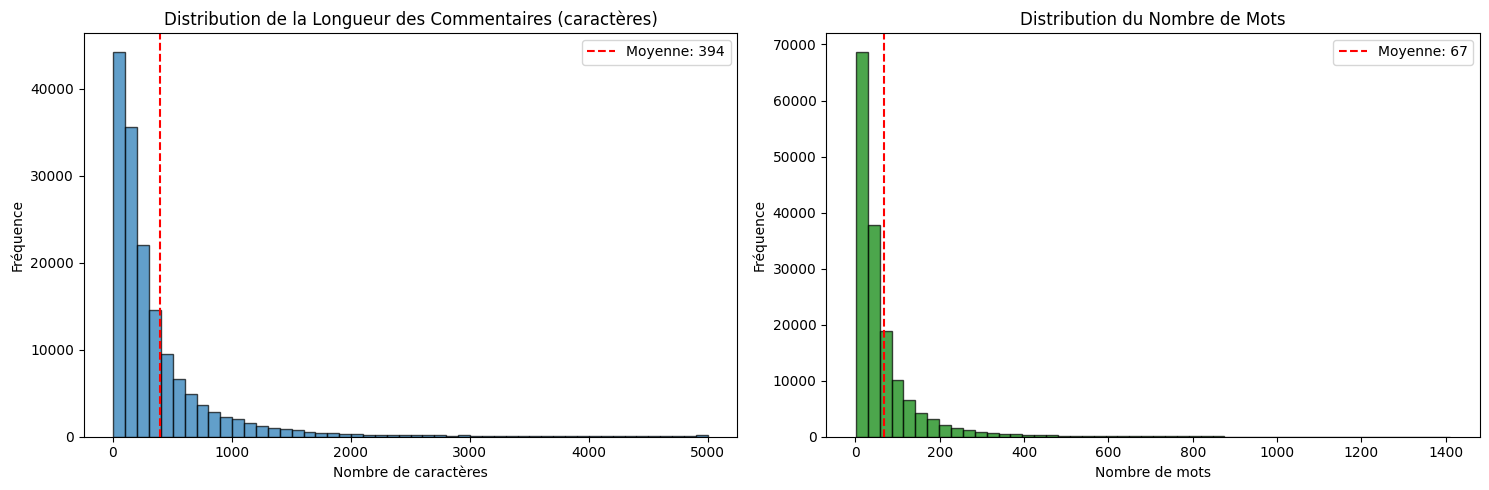

Statistiques de longueur:
Moyenne caractères: 394.07
Moyenne mots: 67.27
Max caractères: 5000
Max mots: 1411


In [101]:
# Distribution de la longueur des commentaires
df['text_length'] = df['comment_text'].apply(len)
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Longueur en caractères
axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de caractères')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de la Longueur des Commentaires (caractères)')
axes[0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["text_length"].mean():.0f}')
axes[0].legend()

# Nombre de mots
axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution du Nombre de Mots')
axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["word_count"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Statistiques de longueur:")
print(f"Moyenne caractères: {df['text_length'].mean():.2f}")
print(f"Moyenne mots: {df['word_count'].mean():.2f}")
print(f"Max caractères: {df['text_length'].max()}")
print(f"Max mots: {df['word_count'].max()}")

## 5. Preprocessing du Texte

In [102]:
def preprocess_text(text, remove_stopwords=False, normalize=None):
    """
    Prétraitement du texte avec options configurables.
    
    Args:
        text (str): Texte à prétraiter
        remove_stopwords (bool): Supprimer les stopwords
        normalize (str): Type de normalisation ('stem', 'lemma', ou None)
    
    Returns:
        str: Texte prétraité
    """
    if pd.isna(text):
        return ""
    
    # Conversion en minuscules et tokenization
    text = str(text).lower()
    tokens = word_tokenize(text)
    
    # Suppression des stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
    
    # Normalisation
    if normalize == 'stem':
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        tokens = [stemmer.stem(token) for token in tokens]
    elif normalize == 'lemma':
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Filtrer les tokens alphabétiques uniquement
    tokens = [token for token in tokens if token.isalpha()]
    
    return ' '.join(tokens)

In [103]:
# Échantillon pour tester le preprocessing (pour accélérer)
# Commentez cette ligne pour utiliser tout le dataset
#df_sample = df.sample(n=50000, random_state=RANDOM_STATE).copy()

print(f"Taille de l'échantillon: {len(df_sample)} commentaires")
print("\nPrétraitement en cours...")

Taille de l'échantillon: 159571 commentaires

Prétraitement en cours...


In [104]:
# Créer différentes versions du texte prétraité
tqdm.pandas(desc="Preprocessing basique")
df_sample['text_clean'] = df_sample['comment_text'].progress_apply(
    lambda x: preprocess_text(x, remove_stopwords=False, normalize=None)
)

tqdm.pandas(desc="Preprocessing avec stemming")
df_sample['text_stem'] = df_sample['comment_text'].progress_apply(
    lambda x: preprocess_text(x, remove_stopwords=True, normalize='stem')
)

tqdm.pandas(desc="Preprocessing avec lemmatization")
df_sample['text_lemma'] = df_sample['comment_text'].progress_apply(
    lambda x: preprocess_text(x, remove_stopwords=True, normalize='lemma')
)

print("\nPrétraitement terminé!")
print(f"\nExemple de transformation:")
idx = 1
print(f"\nOriginal: {df_sample.iloc[idx]['comment_text'][:200]}")
print(f"\nClean: {df_sample.iloc[idx]['text_clean'][:200]}")
print(f"\nStem: {df_sample.iloc[idx]['text_stem'][:200]}")
print(f"\nLemma: {df_sample.iloc[idx]['text_lemma'][:200]}")

Preprocessing avec lemmatization: 100%|██████████| 159571/159571 [02:11<00:00, 1211.04it/s]


Prétraitement terminé!

Exemple de transformation:

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

Clean: he matches this background colour i seemingly stuck with thanks talk january utc

Stem: match background colour seem stuck thank talk januari utc

Lemma: match background colour seemingly stuck thanks talk january utc


## 6. Préparation des Données pour l'Entraînement

In [105]:
# Définir les colonnes de texte et de labels
text_column = 'text_clean'  # Vous pouvez changer pour 'text_stem' ou 'text_lemma'
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Séparer X et y
X = df_sample[text_column]
y = df_sample[label_cols]

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y['toxic']
)

print(f"Données d'entraînement: {X_train.shape[0]} commentaires")
print(f"Données de test: {X_test.shape[0]} commentaires")
print(f"\nDistribution des labels dans le train set:")
print(y_train.sum())

Données d'entraînement: 127656 commentaires
Données de test: 31915 commentaires

Distribution des labels dans le train set:
toxic            12235
severe_toxic      1284
obscene           6739
threat             381
insult            6287
identity_hate     1116
dtype: int64


## 7. Modèles de Classification Multi-Label

Nous utiliserons `OneVsRestClassifier` pour transformer les classificateurs classiques en classificateurs multi-label.

In [106]:
# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate(model, model_name, X_train, X_test, y_train, y_test):
    """
    Entraîne et évalue un modèle de classification multi-label.
    """
    print(f"\n{'='*60}")
    print(f"Modèle: {model_name}")
    print(f"{'='*60}")
    
    # Entraînement
    print("Entraînement en cours...")
    model.fit(X_train, y_train)
    
    # Prédictions
    print("Prédictions en cours...")
    y_pred = model.predict(X_test)
    
    # Métriques globales
    print("\nMétriques globales (multi-label):")
    print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
    print(f"Jaccard Score (samples): {jaccard_score(y_test, y_pred, average='samples'):.4f}")
    print(f"F1 Score (micro): {f1_score(y_test, y_pred, average='micro'):.4f}")
    print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    
    # Métriques par label
    print("\nMétriques par label:")
    for i, label in enumerate(label_cols):
        f1 = f1_score(y_test.iloc[:, i], y_pred[:, i])
        print(f"{label:15s}: F1={f1:.4f}")
    
    # Classification report détaillé pour chaque label
    print("\nRapport de classification détaillé:")
    for i, label in enumerate(label_cols):
        print(f"\n--- {label.upper()} ---")
        print(classification_report(y_test.iloc[:, i], y_pred[:, i], 
                                   target_names=['Non-toxic', 'Toxic'], 
                                   zero_division=0))
    
    return model, y_pred

### 7.1 Modèle 1: Multinomial Naive Bayes

In [107]:
# Pipeline avec TF-IDF + Naive Bayes Multi-Label
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2))),
    ('clf', OneVsRestClassifier(MultinomialNB(alpha=0.1)))
])

nb_model, nb_predictions = train_and_evaluate(
    nb_pipeline, 
    "Multinomial Naive Bayes (Multi-Label)",
    X_train, X_test, y_train, y_test
)


Modèle: Multinomial Naive Bayes (Multi-Label)
Entraînement en cours...
Prédictions en cours...

Métriques globales (multi-label):
Hamming Loss: 0.0211
Jaccard Score (samples): 0.0453
F1 Score (micro): 0.6670
F1 Score (macro): 0.4426
F1 Score (weighted): 0.6541

Métriques par label:
toxic          : F1=0.7256
severe_toxic   : F1=0.3888
obscene        : F1=0.7136
threat         : F1=0.0404
insult         : F1=0.6330
identity_hate  : F1=0.1543

Rapport de classification détaillé:

--- TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.96      0.99      0.97     28856
       Toxic       0.83      0.64      0.73      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.81      0.85     31915
weighted avg       0.95      0.95      0.95     31915


--- SEVERE_TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.99      1.00      1.00     31604
       Toxic       0.59      0.29      0.39 

### 7.2 Modèle 2: Logistic Regression

In [108]:
# Pipeline avec TF-IDF + Logistic Regression Multi-Label
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2))),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, C=1.0, random_state=RANDOM_STATE)))
])

lr_model, lr_predictions = train_and_evaluate(
    lr_pipeline,
    "Logistic Regression (Multi-Label)",
    X_train, X_test, y_train, y_test
)


Modèle: Logistic Regression (Multi-Label)
Entraînement en cours...
Prédictions en cours...

Métriques globales (multi-label):
Hamming Loss: 0.0201
Jaccard Score (samples): 0.0399
F1 Score (micro): 0.6520
F1 Score (macro): 0.4642
F1 Score (weighted): 0.6435

Métriques par label:
toxic          : F1=0.7029
severe_toxic   : F1=0.2899
obscene        : F1=0.7120
threat         : F1=0.1964
insult         : F1=0.6210
identity_hate  : F1=0.2629

Rapport de classification détaillé:

--- TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.96      1.00      0.98     28856
       Toxic       0.94      0.56      0.70      3059

    accuracy                           0.95     31915
   macro avg       0.95      0.78      0.84     31915
weighted avg       0.95      0.95      0.95     31915


--- SEVERE_TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.99      1.00      1.00     31604
       Toxic       0.58      0.19      0.29     

### 7.3 Modèle 3: Random Forest

In [109]:
# Pipeline avec TF-IDF + Random Forest Multi-Label
# Note: Random Forest peut être lent avec de grandes features TF-IDF
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1, 2), max_features=5000)),  # Limiter les features
    ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)))
])

rf_model, rf_predictions = train_and_evaluate(
    rf_pipeline,
    "Random Forest (Multi-Label)",
    X_train, X_test, y_train, y_test
)


Modèle: Random Forest (Multi-Label)
Entraînement en cours...
Prédictions en cours...

Métriques globales (multi-label):
Hamming Loss: 0.0206
Jaccard Score (samples): 0.0411
F1 Score (micro): 0.6554
F1 Score (macro): 0.4143
F1 Score (weighted): 0.6386

Métriques par label:
toxic          : F1=0.6966
severe_toxic   : F1=0.1551
obscene        : F1=0.7569
threat         : F1=0.1121
insult         : F1=0.6154
identity_hate  : F1=0.1497

Rapport de classification détaillé:

--- TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.96      0.99      0.97     28856
       Toxic       0.91      0.57      0.70      3059

    accuracy                           0.95     31915
   macro avg       0.93      0.78      0.84     31915
weighted avg       0.95      0.95      0.95     31915


--- SEVERE_TOXIC ---
              precision    recall  f1-score   support

   Non-toxic       0.99      1.00      1.00     31604
       Toxic       0.56      0.09      0.16       311


## 7.4 Optimisation des Hyperparamètres

### Stratégie d'optimisation en 2 phases :

**Phase 1 - Optimisation Globale :**
- Optimiser chaque modèle sur le F1 micro global (tous les labels)
- Vérifier si le "meilleur modèle par label" a changé après optimisation globale

**Phase 2 - Optimisation Spécifique par Label :**
- Pour chaque label, optimiser uniquement le modèle qui est le meilleur pour ce label
- Chaque modèle est fine-tuné pour maximiser sa performance sur son label spécifique

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

# Fonction pour optimiser un modèle (globalement ou par label)
def optimize_model(pipeline, param_grid, X_train, y_train, model_name, scoring='f1_micro', cv=3):
    """
    Optimise les hyperparamètres d'un modèle avec GridSearchCV.
    
    Args:
        scoring: 'f1_micro' pour optimisation globale, ou callable pour un label spécifique
    """
    print(f"\n{'='*60}")
    print(f"Optimisation: {model_name}")
    print(f"{'='*60}")
    print(f"Scoring: {scoring if isinstance(scoring, str) else 'custom (label-specific)'}")
    print(f"Paramètres testés: {param_grid}")
    print(f"\nRecherche en cours (cv={cv})...")
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Fonction pour créer un scorer spécifique à un label
def make_label_scorer(label_idx):
    """Crée un scorer F1 pour un label spécifique."""
    from sklearn.metrics import make_scorer
    
    def label_f1(y_true, y_pred):
        return f1_score(y_true.iloc[:, label_idx] if hasattr(y_true, 'iloc') else y_true[:, label_idx], 
                       y_pred[:, label_idx])
    
    return make_scorer(label_f1)

## PHASE 1 : Optimisation Globale

On optimise d'abord chaque modèle sur le F1 micro global pour voir si les "champions" par label changent.

In [111]:
# Pipeline Naive Bayes pour optimisation
nb_pipeline_opt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])

# Grille de paramètres pour Naive Bayes
nb_param_grid = {
    'tfidf__max_df': [0.5, 0.7],
    'tfidf__min_df': [3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__alpha': [0.01, 0.1, 1.0]
}

nb_best_model, nb_best_params, nb_best_score = optimize_model(
    nb_pipeline_opt, nb_param_grid, X_train, y_train, "Naive Bayes"
)


Optimisation: Naive Bayes
Scoring: f1_micro
Paramètres testés: {'tfidf__max_df': [0.5, 0.7], 'tfidf__min_df': [3, 5], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'clf__estimator__alpha': [0.01, 0.1, 1.0]}

Recherche en cours (cv=3)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Meilleurs paramètres: {'clf__estimator__alpha': 0.1, 'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Meilleur score: 0.6467


### 7.4.2 Optimisation Logistic Regression

In [112]:
# Pipeline Logistic Regression pour optimisation
lr_pipeline_opt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)))
])

# Grille de paramètres pour Logistic Regression
lr_param_grid = {
    'tfidf__max_df': [0.5, 0.7],
    'tfidf__min_df': [3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__C': [0.1, 1.0, 10.0],
    'clf__estimator__solver': ['lbfgs', 'liblinear']
}

lr_best_model, lr_best_params, lr_best_score = optimize_model(
    lr_pipeline_opt, lr_param_grid, X_train, y_train, "Logistic Regression"
)


Optimisation: Logistic Regression
Scoring: f1_micro
Paramètres testés: {'tfidf__max_df': [0.5, 0.7], 'tfidf__min_df': [3, 5], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'clf__estimator__C': [0.1, 1.0, 10.0], 'clf__estimator__solver': ['lbfgs', 'liblinear']}

Recherche en cours (cv=3)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Meilleurs paramètres: {'clf__estimator__C': 10.0, 'clf__estimator__solver': 'lbfgs', 'tfidf__max_df': 0.7, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}
Meilleur score: 0.7121


### 7.4.3 Optimisation Random Forest

In [113]:
# Pipeline Random Forest pour optimisation
rf_pipeline_opt = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Limiter pour la vitesse
    ('clf', OneVsRestClassifier(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)))
])

# Grille de paramètres pour Random Forest
rf_param_grid = {
    'tfidf__max_df': [0.5, 0.7],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__estimator__n_estimators': [100, 200],
    'clf__estimator__max_depth': [None, 50, 100],
    'clf__estimator__min_samples_split': [2, 5]
}

rf_best_model, rf_best_params, rf_best_score = optimize_model(
    rf_pipeline_opt, rf_param_grid, X_train, y_train, "Random Forest"
)


Optimisation: Random Forest
Scoring: f1_micro
Paramètres testés: {'tfidf__max_df': [0.5, 0.7], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'clf__estimator__n_estimators': [100, 200], 'clf__estimator__max_depth': [None, 50, 100], 'clf__estimator__min_samples_split': [2, 5]}

Recherche en cours (cv=3)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Meilleurs paramètres: {'clf__estimator__max_depth': None, 'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 200, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}
Meilleur score: 0.6549


### 7.4.4 Évaluation des Modèles Optimisés

In [114]:
# Évaluer les modèles optimisés sur le test set
print("="*60)
print("ÉVALUATION DES MODÈLES OPTIMISÉS")
print("="*60)

# Prédictions avec les modèles optimisés
nb_opt_predictions = nb_best_model.predict(X_test)
lr_opt_predictions = lr_best_model.predict(X_test)
rf_opt_predictions = rf_best_model.predict(X_test)

# Comparaison des résultats
optimized_models = {
    'Naive Bayes (Optimisé)': nb_opt_predictions,
    'Logistic Regression (Optimisé)': lr_opt_predictions,
    'Random Forest (Optimisé)': rf_opt_predictions
}

results_optimized = []
for model_name, predictions in optimized_models.items():
    row = {
        'Model': model_name,
        'Hamming Loss': hamming_loss(y_test, predictions),
        'Jaccard Score': jaccard_score(y_test, predictions, average='samples'),
        'F1 Micro': f1_score(y_test, predictions, average='micro'),
        'F1 Macro': f1_score(y_test, predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, predictions, average='weighted')
    }
    results_optimized.append(row)

results_opt_df = pd.DataFrame(results_optimized)
print("\nRésultats des modèles optimisés:")
print(results_opt_df.to_string(index=False))

ÉVALUATION DES MODÈLES OPTIMISÉS

Résultats des modèles optimisés:
                         Model  Hamming Loss  Jaccard Score  F1 Micro  F1 Macro  F1 Weighted
        Naive Bayes (Optimisé)      0.021061       0.045273  0.666997  0.442606     0.654142
Logistic Regression (Optimisé)      0.018048       0.051216  0.720975  0.543746     0.714469
      Random Forest (Optimisé)      0.020064       0.042390  0.665797  0.418954     0.647873



COMPARAISON AVANT / APRÈS OPTIMISATION

Tableau comparatif complet:
                         Model  Hamming Loss  Jaccard Score  F1 Micro  F1 Macro  F1 Weighted
                   Naive Bayes      0.021061       0.045273  0.666997  0.442606     0.654142
           Logistic Regression      0.020064       0.039880  0.651993  0.464186     0.643486
                 Random Forest      0.020570       0.041107  0.655411  0.414325     0.638636
        Naive Bayes (Optimisé)      0.021061       0.045273  0.666997  0.442606     0.654142
Logistic Regression (Optimisé)      0.018048       0.051216  0.720975  0.543746     0.714469
      Random Forest (Optimisé)      0.020064       0.042390  0.665797  0.418954     0.647873


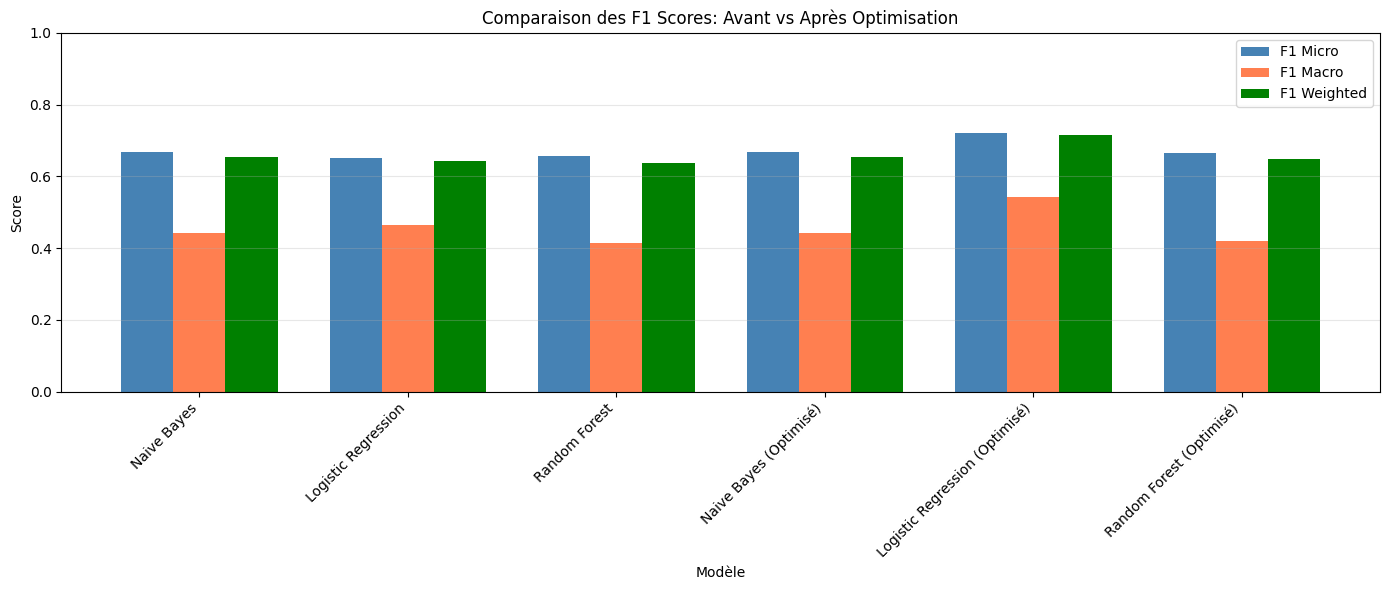

In [115]:
# Comparaison avant/après optimisation
print("\n" + "="*60)
print("COMPARAISON AVANT / APRÈS OPTIMISATION")
print("="*60)

# Combiner les résultats
comparison_df = pd.concat([results_df, results_opt_df], ignore_index=True)
print("\nTableau comparatif complet:")
print(comparison_df.to_string(index=False))

# Visualisation
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['F1 Micro'], width, label='F1 Micro', color='steelblue')
bars2 = ax.bar(x, comparison_df['F1 Macro'], width, label='F1 Macro', color='coral')
bars3 = ax.bar(x + width, comparison_df['F1 Weighted'], width, label='F1 Weighted', color='green')

ax.set_xlabel('Modèle')
ax.set_ylabel('Score')
ax.set_title('Comparaison des F1 Scores: Avant vs Après Optimisation')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


F1 Score par Label (Modèles Optimisés):
               Naive Bayes (Optimisé)  Logistic Regression (Optimisé)  \
toxic                        0.725559                        0.782530   
severe_toxic                 0.388769                        0.359504   
obscene                      0.713578                        0.784695   
threat                       0.040404                        0.246154   
insult                       0.633021                        0.657287   
identity_hate                0.154303                        0.432304   

               Random Forest (Optimisé)  
toxic                          0.710217  
severe_toxic                   0.120690  
obscene                        0.765831  
threat                         0.132075  
insult                         0.624199  
identity_hate                  0.160714  


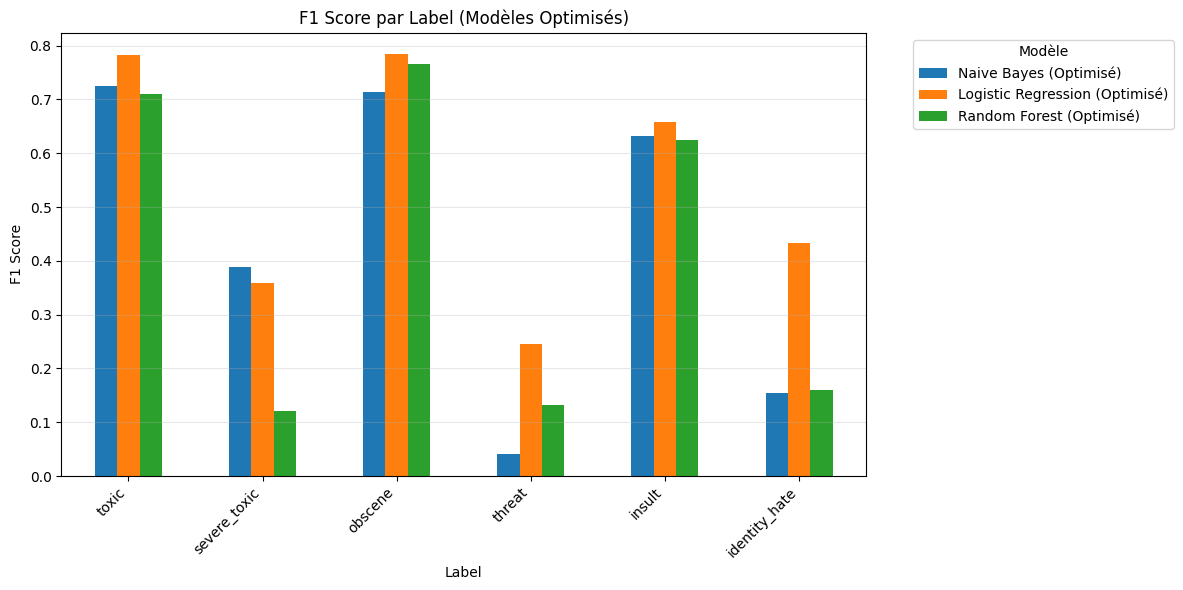

In [116]:
# F1 Score par label pour les modèles optimisés
print("\nF1 Score par Label (Modèles Optimisés):")
f1_by_label_opt = {}
for model_name, predictions in optimized_models.items():
    f1_scores = []
    for i, label in enumerate(label_cols):
        f1 = f1_score(y_test.iloc[:, i], predictions[:, i])
        f1_scores.append(f1)
    f1_by_label_opt[model_name] = f1_scores

f1_opt_df = pd.DataFrame(f1_by_label_opt, index=label_cols)
print(f1_opt_df)

# Visualisation
f1_opt_df.plot(kind='bar', figsize=(12, 6))
plt.title('F1 Score par Label (Modèles Optimisés)')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Modèle', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [117]:
# Résumé des meilleurs paramètres trouvés
print("="*60)
print("RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES")
print("="*60)

print("\n Naive Bayes:")
for param, value in nb_best_params.items():
    print(f"   {param}: {value}")

print("\n Logistic Regression:")
for param, value in lr_best_params.items():
    print(f"   {param}: {value}")

print("\n Random Forest:")
for param, value in rf_best_params.items():
    print(f"   {param}: {value}")

RÉSUMÉ DES MEILLEURS HYPERPARAMÈTRES

 Naive Bayes:
   clf__estimator__alpha: 0.1
   tfidf__max_df: 0.5
   tfidf__min_df: 5
   tfidf__ngram_range: (1, 2)

 Logistic Regression:
   clf__estimator__C: 10.0
   clf__estimator__solver: lbfgs
   tfidf__max_df: 0.7
   tfidf__min_df: 3
   tfidf__ngram_range: (1, 1)

 Random Forest:
   clf__estimator__max_depth: None
   clf__estimator__min_samples_split: 2
   clf__estimator__n_estimators: 200
   tfidf__max_df: 0.5
   tfidf__ngram_range: (1, 1)


### 7.4.5 Amélioration de Chaque Modèle Après Optimisation

In [118]:
# Calculer l'amélioration pour chaque modèle
print("="*70)
print("AMÉLIORATION DE CHAQUE MODÈLE APRÈS OPTIMISATION")
print("="*70)

# Résultats avant optimisation
avant_opt = {
    'Naive Bayes': {
        'F1 Micro': f1_score(y_test, nb_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, nb_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, nb_predictions, average='weighted')
    },
    'Logistic Regression': {
        'F1 Micro': f1_score(y_test, lr_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, lr_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, lr_predictions, average='weighted')
    },
    'Random Forest': {
        'F1 Micro': f1_score(y_test, rf_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, rf_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, rf_predictions, average='weighted')
    }
}

# Résultats après optimisation
apres_opt = {
    'Naive Bayes': {
        'F1 Micro': f1_score(y_test, nb_opt_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, nb_opt_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, nb_opt_predictions, average='weighted')
    },
    'Logistic Regression': {
        'F1 Micro': f1_score(y_test, lr_opt_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, lr_opt_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, lr_opt_predictions, average='weighted')
    },
    'Random Forest': {
        'F1 Micro': f1_score(y_test, rf_opt_predictions, average='micro'),
        'F1 Macro': f1_score(y_test, rf_opt_predictions, average='macro'),
        'F1 Weighted': f1_score(y_test, rf_opt_predictions, average='weighted')
    }
}

# Afficher l'amélioration pour chaque modèle
for model_name in ['Naive Bayes', 'Logistic Regression', 'Random Forest']:
    print(f"\n{'='*50}")
    print(f"📊 {model_name}")
    print(f"{'='*50}")
    print(f"{'Métrique':<15} {'Avant':<10} {'Après':<10} {'Δ':<10} {'Amélioration'}")
    print("-"*55)
    
    for metric in ['F1 Micro', 'F1 Macro', 'F1 Weighted']:
        avant = avant_opt[model_name][metric]
        apres = apres_opt[model_name][metric]
        delta = apres - avant
        pct = (delta / avant) * 100 if avant != 0 else 0
        
        if delta > 0:
            status = f"✅ +{pct:.2f}%"
        elif delta < 0:
            status = f"❌ {pct:.2f}%"
        else:
            status = "➖ 0%"
        
        print(f"{metric:<15} {avant:<10.4f} {apres:<10.4f} {delta:<+10.4f} {status}")

AMÉLIORATION DE CHAQUE MODÈLE APRÈS OPTIMISATION

📊 Naive Bayes
Métrique        Avant      Après      Δ          Amélioration
-------------------------------------------------------
F1 Micro        0.6670     0.6670     +0.0000    ➖ 0%
F1 Macro        0.4426     0.4426     +0.0000    ➖ 0%
F1 Weighted     0.6541     0.6541     +0.0000    ➖ 0%

📊 Logistic Regression
Métrique        Avant      Après      Δ          Amélioration
-------------------------------------------------------
F1 Micro        0.6520     0.7210     +0.0690    ✅ +10.58%
F1 Macro        0.4642     0.5437     +0.0796    ✅ +17.14%
F1 Weighted     0.6435     0.7145     +0.0710    ✅ +11.03%

📊 Random Forest
Métrique        Avant      Après      Δ          Amélioration
-------------------------------------------------------
F1 Micro        0.6554     0.6658     +0.0104    ✅ +1.58%
F1 Macro        0.4143     0.4190     +0.0046    ✅ +1.12%
F1 Weighted     0.6386     0.6479     +0.0092    ✅ +1.45%


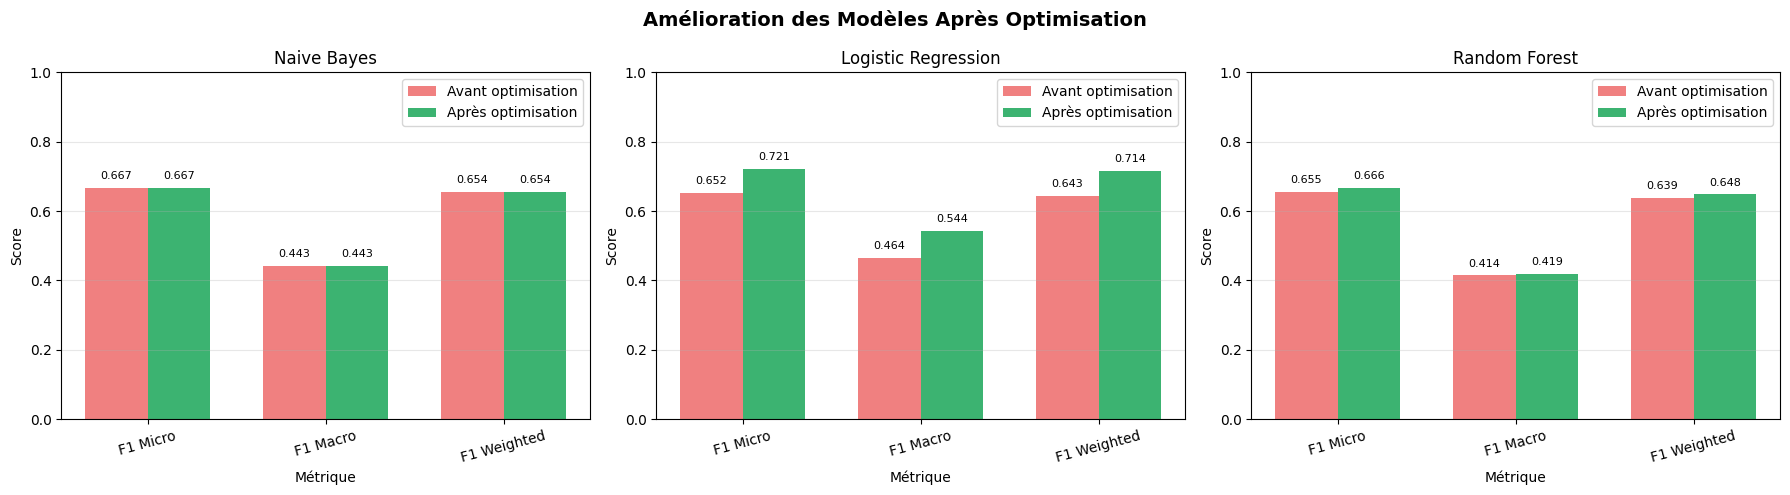

In [119]:
# Visualisation de l'amélioration
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
metrics = ['F1 Micro', 'F1 Macro', 'F1 Weighted']
x = np.arange(len(metrics))
width = 0.35

for idx, model_name in enumerate(models):
    avant_vals = [avant_opt[model_name][m] for m in metrics]
    apres_vals = [apres_opt[model_name][m] for m in metrics]
    
    bars1 = axes[idx].bar(x - width/2, avant_vals, width, label='Avant optimisation', color='lightcoral')
    bars2 = axes[idx].bar(x + width/2, apres_vals, width, label='Après optimisation', color='mediumseagreen')
    
    axes[idx].set_xlabel('Métrique')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f'{model_name}')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(metrics, rotation=15)
    axes[idx].legend()
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars1, avant_vals):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    for bar, val in zip(bars2, apres_vals):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                      f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Amélioration des Modèles Après Optimisation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.4.6 Meilleur Modèle par Label : Avant vs Après Optimisation

In [120]:
# F1 par label AVANT optimisation
print("="*80)
print("F1 SCORE PAR LABEL - AVANT OPTIMISATION")
print("="*80)

f1_avant = {}
predictions_avant = {
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions,
    'Random Forest': rf_predictions
}

for model_name, preds in predictions_avant.items():
    f1_scores = []
    for i, label in enumerate(label_cols):
        f1 = f1_score(y_test.iloc[:, i], preds[:, i])
        f1_scores.append(f1)
    f1_avant[model_name] = f1_scores

f1_avant_df = pd.DataFrame(f1_avant, index=label_cols)
print("\nF1 Score par Label (AVANT optimisation):")
print(f1_avant_df.round(4))

# Meilleur modèle par label AVANT
best_avant = {}
for label in label_cols:
    best_model = f1_avant_df.loc[label].idxmax()
    best_score = f1_avant_df.loc[label].max()
    best_avant[label] = {'model': best_model, 'score': best_score}

print("\n📌 Meilleur modèle par label (AVANT):")
for label, info in best_avant.items():
    print(f"   {label:15s}: {info['model']:20s} (F1 = {info['score']:.4f})")

F1 SCORE PAR LABEL - AVANT OPTIMISATION

F1 Score par Label (AVANT optimisation):
               Naive Bayes  Logistic Regression  Random Forest
toxic               0.7256               0.7029         0.6966
severe_toxic        0.3888               0.2899         0.1551
obscene             0.7136               0.7120         0.7569
threat              0.0404               0.1964         0.1121
insult              0.6330               0.6210         0.6154
identity_hate       0.1543               0.2629         0.1497

📌 Meilleur modèle par label (AVANT):
   toxic          : Naive Bayes          (F1 = 0.7256)
   severe_toxic   : Naive Bayes          (F1 = 0.3888)
   obscene        : Random Forest        (F1 = 0.7569)
   threat         : Logistic Regression  (F1 = 0.1964)
   insult         : Naive Bayes          (F1 = 0.6330)
   identity_hate  : Logistic Regression  (F1 = 0.2629)


In [121]:
# F1 par label APRÈS optimisation
print("="*80)
print("F1 SCORE PAR LABEL - APRÈS OPTIMISATION")
print("="*80)

f1_apres = {}
predictions_apres = {
    'Naive Bayes': nb_opt_predictions,
    'Logistic Regression': lr_opt_predictions,
    'Random Forest': rf_opt_predictions
}

for model_name, preds in predictions_apres.items():
    f1_scores = []
    for i, label in enumerate(label_cols):
        f1 = f1_score(y_test.iloc[:, i], preds[:, i])
        f1_scores.append(f1)
    f1_apres[model_name] = f1_scores

f1_apres_df = pd.DataFrame(f1_apres, index=label_cols)
print("\nF1 Score par Label (APRÈS optimisation):")
print(f1_apres_df.round(4))

# Meilleur modèle par label APRÈS
best_apres = {}
for label in label_cols:
    best_model = f1_apres_df.loc[label].idxmax()
    best_score = f1_apres_df.loc[label].max()
    best_apres[label] = {'model': best_model, 'score': best_score}

print("\n📌 Meilleur modèle par label (APRÈS):")
for label, info in best_apres.items():
    print(f"   {label:15s}: {info['model']:20s} (F1 = {info['score']:.4f})")

F1 SCORE PAR LABEL - APRÈS OPTIMISATION

F1 Score par Label (APRÈS optimisation):
               Naive Bayes  Logistic Regression  Random Forest
toxic               0.7256               0.7825         0.7102
severe_toxic        0.3888               0.3595         0.1207
obscene             0.7136               0.7847         0.7658
threat              0.0404               0.2462         0.1321
insult              0.6330               0.6573         0.6242
identity_hate       0.1543               0.4323         0.1607

📌 Meilleur modèle par label (APRÈS):
   toxic          : Logistic Regression  (F1 = 0.7825)
   severe_toxic   : Naive Bayes          (F1 = 0.3888)
   obscene        : Logistic Regression  (F1 = 0.7847)
   threat         : Logistic Regression  (F1 = 0.2462)
   insult         : Logistic Regression  (F1 = 0.6573)
   identity_hate  : Logistic Regression  (F1 = 0.4323)


In [122]:
# Comparaison : Le meilleur modèle a-t-il changé ?
print("="*80)
print("COMPARAISON : LE MEILLEUR MODÈLE PAR LABEL A-T-IL CHANGÉ ?")
print("="*80)

print(f"\n{'Label':<15} {'AVANT':<22} {'APRÈS':<22} {'Changé?':<10} {'Δ F1'}")
print("-"*80)

for label in label_cols:
    avant_model = best_avant[label]['model']
    avant_score = best_avant[label]['score']
    apres_model = best_apres[label]['model']
    apres_score = best_apres[label]['score']
    
    changed = "🔄 OUI" if avant_model != apres_model else "➖ NON"
    delta = apres_score - avant_score
    delta_str = f"+{delta:.4f}" if delta >= 0 else f"{delta:.4f}"
    
    print(f"{label:<15} {avant_model:<22} {apres_model:<22} {changed:<10} {delta_str}")

# Résumé
nb_changes = sum(1 for l in label_cols if best_avant[l]['model'] != best_apres[l]['model'])
print(f"\n📊 Résumé: {nb_changes}/{len(label_cols)} labels ont changé de meilleur modèle après optimisation")

COMPARAISON : LE MEILLEUR MODÈLE PAR LABEL A-T-IL CHANGÉ ?

Label           AVANT                  APRÈS                  Changé?    Δ F1
--------------------------------------------------------------------------------
toxic           Naive Bayes            Logistic Regression    🔄 OUI      +0.0570
severe_toxic    Naive Bayes            Naive Bayes            ➖ NON      +0.0000
obscene         Random Forest          Logistic Regression    🔄 OUI      +0.0278
threat          Logistic Regression    Logistic Regression    ➖ NON      +0.0497
insult          Naive Bayes            Logistic Regression    🔄 OUI      +0.0243
identity_hate   Logistic Regression    Logistic Regression    ➖ NON      +0.1694

📊 Résumé: 3/6 labels ont changé de meilleur modèle après optimisation


In [123]:
# Amélioration par label pour chaque modèle
print("="*80)
print("AMÉLIORATION PAR LABEL POUR CHAQUE MODÈLE")
print("="*80)

for model_name in ['Naive Bayes', 'Logistic Regression', 'Random Forest']:
    print(f"\n📊 {model_name}:")
    print(f"{'Label':<15} {'Avant':<10} {'Après':<10} {'Δ':<10} {'Amélioration'}")
    print("-"*55)
    
    for i, label in enumerate(label_cols):
        avant = f1_avant[model_name][i]
        apres = f1_apres[model_name][i]
        delta = apres - avant
        pct = (delta / avant) * 100 if avant != 0 else 0
        
        if delta > 0.001:
            status = f"✅ +{pct:.1f}%"
        elif delta < -0.001:
            status = f"❌ {pct:.1f}%"
        else:
            status = "➖ ~0%"
        
        print(f"{label:<15} {avant:<10.4f} {apres:<10.4f} {delta:<+10.4f} {status}")

AMÉLIORATION PAR LABEL POUR CHAQUE MODÈLE

📊 Naive Bayes:
Label           Avant      Après      Δ          Amélioration
-------------------------------------------------------
toxic           0.7256     0.7256     +0.0000    ➖ ~0%
severe_toxic    0.3888     0.3888     +0.0000    ➖ ~0%
obscene         0.7136     0.7136     +0.0000    ➖ ~0%
threat          0.0404     0.0404     +0.0000    ➖ ~0%
insult          0.6330     0.6330     +0.0000    ➖ ~0%
identity_hate   0.1543     0.1543     +0.0000    ➖ ~0%

📊 Logistic Regression:
Label           Avant      Après      Δ          Amélioration
-------------------------------------------------------
toxic           0.7029     0.7825     +0.0796    ✅ +11.3%
severe_toxic    0.2899     0.3595     +0.0696    ✅ +24.0%
obscene         0.7120     0.7847     +0.0727    ✅ +10.2%
threat          0.1964     0.2462     +0.0497    ✅ +25.3%
insult          0.6210     0.6573     +0.0363    ✅ +5.8%
identity_hate   0.2629     0.4323     +0.1694    ✅ +64.5%

📊 Ra

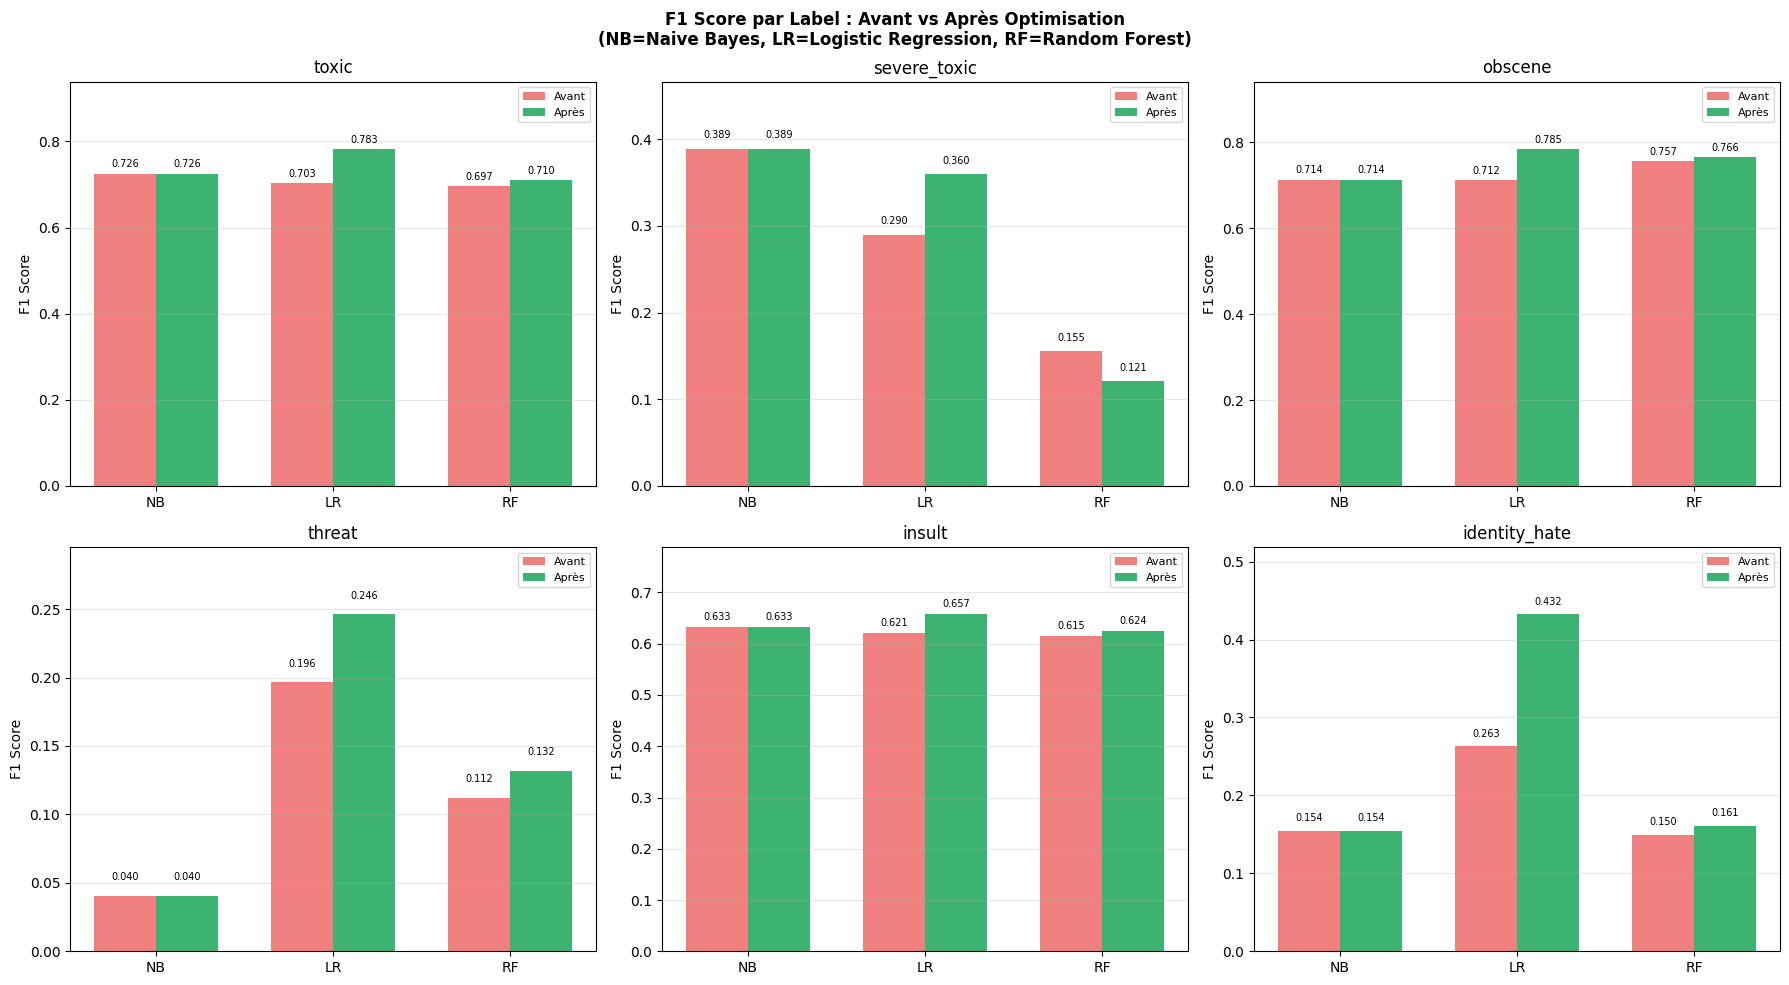

In [124]:
# Visualisation comparative par label
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, label in enumerate(label_cols):
    models = ['Naive Bayes', 'Logistic Regression', 'Random Forest']
    avant_scores = [f1_avant[m][idx] for m in models]
    apres_scores = [f1_apres[m][idx] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, avant_scores, width, label='Avant', color='lightcoral')
    bars2 = axes[idx].bar(x + width/2, apres_scores, width, label='Après', color='mediumseagreen')
    
    axes[idx].set_ylabel('F1 Score')
    axes[idx].set_title(f'{label}')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(['NB', 'LR', 'RF'])
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].set_ylim([0, max(max(avant_scores), max(apres_scores)) * 1.2])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs
    for bar, val in zip(bars1, avant_scores):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{val:.3f}', ha='center', va='bottom', fontsize=7)
    for bar, val in zip(bars2, apres_scores):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{val:.3f}', ha='center', va='bottom', fontsize=7)

plt.suptitle('F1 Score par Label : Avant vs Après Optimisation\n(NB=Naive Bayes, LR=Logistic Regression, RF=Random Forest)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.4.7 Nouvel Ensemble avec Modèles Optimisés

In [125]:
# Créer le nouvel ensemble avec les modèles optimisés
print("="*80)
print("NOUVEL ENSEMBLE AVEC MODÈLES OPTIMISÉS")
print("="*80)

# Sélectionner le meilleur modèle optimisé pour chaque label
best_model_per_label_opt = {}
best_predictions_per_label_opt = {}

for i, label in enumerate(label_cols):
    best_f1 = 0
    best_model_name = None
    best_pred = None
    
    for model_name, preds in predictions_apres.items():
        f1 = f1_score(y_test.iloc[:, i], preds[:, i])
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = model_name
            best_pred = preds[:, i]
    
    best_model_per_label_opt[label] = best_model_name
    best_predictions_per_label_opt[label] = best_pred

# Créer les prédictions ensemble optimisé
ensemble_opt_predictions = np.column_stack([best_predictions_per_label_opt[label] for label in label_cols])

# Métriques de l'ensemble optimisé
print("\n📌 Meilleur modèle optimisé par label:")
for label, model in best_model_per_label_opt.items():
    score = f1_apres_df.loc[label, model]
    print(f"   {label:15s}: {model:20s} (F1 = {score:.4f})")

print("\n" + "="*60)
print("MÉTRIQUES DE L'ENSEMBLE OPTIMISÉ")
print("="*60)
print(f"Hamming Loss: {hamming_loss(y_test, ensemble_opt_predictions):.4f}")
print(f"Jaccard Score: {jaccard_score(y_test, ensemble_opt_predictions, average='samples'):.4f}")
print(f"F1 Micro: {f1_score(y_test, ensemble_opt_predictions, average='micro'):.4f}")
print(f"F1 Macro: {f1_score(y_test, ensemble_opt_predictions, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_test, ensemble_opt_predictions, average='weighted'):.4f}")

NOUVEL ENSEMBLE AVEC MODÈLES OPTIMISÉS

📌 Meilleur modèle optimisé par label:
   toxic          : Logistic Regression  (F1 = 0.7825)
   severe_toxic   : Naive Bayes          (F1 = 0.3888)
   obscene        : Logistic Regression  (F1 = 0.7847)
   threat         : Logistic Regression  (F1 = 0.2462)
   insult         : Logistic Regression  (F1 = 0.6573)
   identity_hate  : Logistic Regression  (F1 = 0.4323)

MÉTRIQUES DE L'ENSEMBLE OPTIMISÉ
Hamming Loss: 0.0179
Jaccard Score: 0.0514
F1 Micro: 0.7227
F1 Macro: 0.5486
F1 Weighted: 0.7158


## PHASE 2 : Optimisation Spécifique par Label

Maintenant que nous savons quel modèle est le meilleur pour chaque label (après optimisation globale), nous allons optimiser chaque modèle **spécifiquement pour son label**.

L'idée : Si Naive Bayes est le meilleur pour "toxic", on l'optimise pour maximiser le F1 sur "toxic" uniquement.

In [126]:
# Identifier le meilleur modèle par label après Phase 1 (optimisation globale)
print("="*80)
print("PHASE 2 : OPTIMISATION SPÉCIFIQUE PAR LABEL")
print("="*80)

print("\n📌 Meilleur modèle par label (après Phase 1 - optimisation globale):")
for label, model in best_model_per_label_opt.items():
    print(f"   {label:15s} → {model}")

# Regrouper les labels par modèle
labels_by_model = {}
for label, model in best_model_per_label_opt.items():
    if model not in labels_by_model:
        labels_by_model[model] = []
    labels_by_model[model].append(label)

print("\n📊 Labels à optimiser par modèle:")
for model, labels in labels_by_model.items():
    print(f"   {model}: {labels}")

PHASE 2 : OPTIMISATION SPÉCIFIQUE PAR LABEL

📌 Meilleur modèle par label (après Phase 1 - optimisation globale):
   toxic           → Logistic Regression
   severe_toxic    → Naive Bayes
   obscene         → Logistic Regression
   threat          → Logistic Regression
   insult          → Logistic Regression
   identity_hate   → Logistic Regression

📊 Labels à optimiser par modèle:
   Logistic Regression: ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']
   Naive Bayes: ['severe_toxic']


In [127]:
# Définir les grilles de paramètres pour chaque modèle
param_grids = {
    'Naive Bayes': {
        'tfidf__max_df': [0.5, 0.7],
        'tfidf__min_df': [3, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__alpha': [0.01, 0.1, 0.5, 1.0]
    },
    'Logistic Regression': {
        'tfidf__max_df': [0.5, 0.7],
        'tfidf__min_df': [3, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__C': [0.1, 1.0, 10.0],
        'clf__estimator__solver': ['lbfgs', 'liblinear']
    },
    'Random Forest': {
        'tfidf__max_df': [0.5, 0.7],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf__estimator__n_estimators': [100, 200],
        'clf__estimator__max_depth': [None, 50],
        'clf__estimator__min_samples_split': [2, 5]
    }
}

# Créer les pipelines de base pour chaque modèle
base_pipelines = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(MultinomialNB()))
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', OneVsRestClassifier(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)))
    ])
}

In [128]:
# Optimisation spécifique par label
# Pour chaque label, on optimise le modèle champion pour ce label

best_models_per_label_phase2 = {}
best_params_per_label_phase2 = {}

for label in label_cols:
    label_idx = label_cols.index(label)
    model_name = best_model_per_label_opt[label]
    
    print(f"\n{'#'*80}")
    print(f"# Optimisation de {model_name} pour le label '{label}'")
    print(f"{'#'*80}")
    
    # Créer le scorer spécifique à ce label
    label_scorer = make_label_scorer(label_idx)
    
    # Cloner le pipeline de base
    pipeline = clone(base_pipelines[model_name])
    
    # Optimiser
    best_model, best_params, best_score = optimize_model(
        pipeline,
        param_grids[model_name],
        X_train, y_train,
        f"{model_name} pour '{label}'",
        scoring=label_scorer,
        cv=3
    )
    
    best_models_per_label_phase2[label] = {
        'model': best_model,
        'model_name': model_name,
        'params': best_params,
        'cv_score': best_score
    }
    
    print(f"\n✅ {label}: Meilleur score CV = {best_score:.4f}")


################################################################################
# Optimisation de Logistic Regression pour le label 'toxic'
################################################################################

Optimisation: Logistic Regression pour 'toxic'
Scoring: custom (label-specific)
Paramètres testés: {'tfidf__max_df': [0.5, 0.7], 'tfidf__min_df': [3, 5], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'clf__estimator__C': [0.1, 1.0, 10.0], 'clf__estimator__solver': ['lbfgs', 'liblinear']}

Recherche en cours (cv=3)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Meilleurs paramètres: {'clf__estimator__C': 10.0, 'clf__estimator__solver': 'lbfgs', 'tfidf__max_df': 0.5, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Meilleur score: 0.7641

✅ toxic: Meilleur score CV = 0.7641

################################################################################
# Optimisation de Naive Bayes pour le label 'severe_toxic'
##########################################

In [129]:
# Évaluer les modèles optimisés par label sur le test set
print("="*80)
print("ÉVALUATION PHASE 2 : MODÈLES OPTIMISÉS PAR LABEL")
print("="*80)

# Créer les prédictions pour chaque label avec son modèle optimisé spécifiquement
phase2_predictions_per_label = {}

for label in label_cols:
    label_idx = label_cols.index(label)
    model = best_models_per_label_phase2[label]['model']
    
    # Prédire
    preds = model.predict(X_test)
    phase2_predictions_per_label[label] = preds[:, label_idx]

# Combiner en matrice de prédictions
phase2_ensemble_predictions = np.column_stack([phase2_predictions_per_label[label] for label in label_cols])

# Calculer F1 par label
print("\n📊 F1 Score par Label (Phase 2 - Optimisation Spécifique):")
print("-"*60)

f1_phase2 = {}
for label in label_cols:
    label_idx = label_cols.index(label)
    f1 = f1_score(y_test.iloc[:, label_idx], phase2_predictions_per_label[label])
    f1_phase2[label] = f1
    model_name = best_models_per_label_phase2[label]['model_name']
    print(f"   {label:15s}: F1 = {f1:.4f} (via {model_name})")

ÉVALUATION PHASE 2 : MODÈLES OPTIMISÉS PAR LABEL

📊 F1 Score par Label (Phase 2 - Optimisation Spécifique):
------------------------------------------------------------
   toxic          : F1 = 0.7796 (via Logistic Regression)
   severe_toxic   : F1 = 0.4738 (via Naive Bayes)
   obscene        : F1 = 0.7841 (via Logistic Regression)
   threat         : F1 = 0.2985 (via Logistic Regression)
   insult         : F1 = 0.6545 (via Logistic Regression)
   identity_hate  : F1 = 0.4019 (via Logistic Regression)


In [130]:
# Comparaison des 3 approches : Avant optimisation vs Phase 1 vs Phase 2
print("="*80)
print("COMPARAISON FINALE : TOUTES LES APPROCHES")
print("="*80)

# Calculer F1 par label pour les 3 approches
comparison_data = []

for label in label_cols:
    label_idx = label_cols.index(label)
    
    # Avant optimisation (ensemble avec modèles de base)
    f1_avant = f1_score(y_test.iloc[:, label_idx], ensemble_predictions[:, label_idx])
    
    # Phase 1 (ensemble avec modèles optimisés globalement)
    f1_phase1 = f1_score(y_test.iloc[:, label_idx], ensemble_opt_predictions[:, label_idx])
    
    # Phase 2 (modèle optimisé spécifiquement pour ce label)
    f1_p2 = f1_phase2[label]
    
    comparison_data.append({
        'Label': label,
        'Avant Opt': f1_avant,
        'Phase 1 (Global)': f1_phase1,
        'Phase 2 (Spécifique)': f1_p2,
        'Δ Phase1': f1_phase1 - f1_avant,
        'Δ Phase2': f1_p2 - f1_phase1
    })

comparison_df_final = pd.DataFrame(comparison_data)
print("\nF1 Score par Label - Comparaison des 3 approches:")
print(comparison_df_final.to_string(index=False))

# Métriques globales
print("\n" + "="*80)
print("MÉTRIQUES GLOBALES DE L'ENSEMBLE")
print("="*80)

metrics_comparison = {
    'Avant Optimisation': {
        'predictions': ensemble_predictions,
    },
    'Phase 1 (Opt Globale)': {
        'predictions': ensemble_opt_predictions,
    },
    'Phase 2 (Opt Spécifique)': {
        'predictions': phase2_ensemble_predictions,
    }
}

print(f"\n{'Approche':<25} {'F1 Micro':<12} {'F1 Macro':<12} {'F1 Weighted':<12} {'Hamming Loss'}")
print("-"*75)

for name, data in metrics_comparison.items():
    preds = data['predictions']
    f1_micro = f1_score(y_test, preds, average='micro')
    f1_macro = f1_score(y_test, preds, average='macro')
    f1_weighted = f1_score(y_test, preds, average='weighted')
    h_loss = hamming_loss(y_test, preds)
    print(f"{name:<25} {f1_micro:<12.4f} {f1_macro:<12.4f} {f1_weighted:<12.4f} {h_loss:.4f}")

COMPARAISON FINALE : TOUTES LES APPROCHES

F1 Score par Label - Comparaison des 3 approches:
        Label  Avant Opt  Phase 1 (Global)  Phase 2 (Spécifique)  Δ Phase1  Δ Phase2
        toxic   0.725559          0.782530              0.779599  0.056971 -0.002930
 severe_toxic   0.388769          0.388769              0.473837  0.000000  0.085068
      obscene   0.756917          0.784695              0.784073  0.027778 -0.000623
       threat   0.196429          0.246154              0.298507  0.049725  0.052354
       insult   0.633021          0.657287              0.654532  0.024266 -0.002755
identity_hate   0.262857          0.432304              0.401937  0.169447 -0.030367

MÉTRIQUES GLOBALES DE L'ENSEMBLE

Approche                  F1 Micro     F1 Macro     F1 Weighted  Hamming Loss
---------------------------------------------------------------------------
Avant Optimisation        0.6812       0.4939       0.6712       0.0202
Phase 1 (Opt Globale)     0.7227       0.5486      

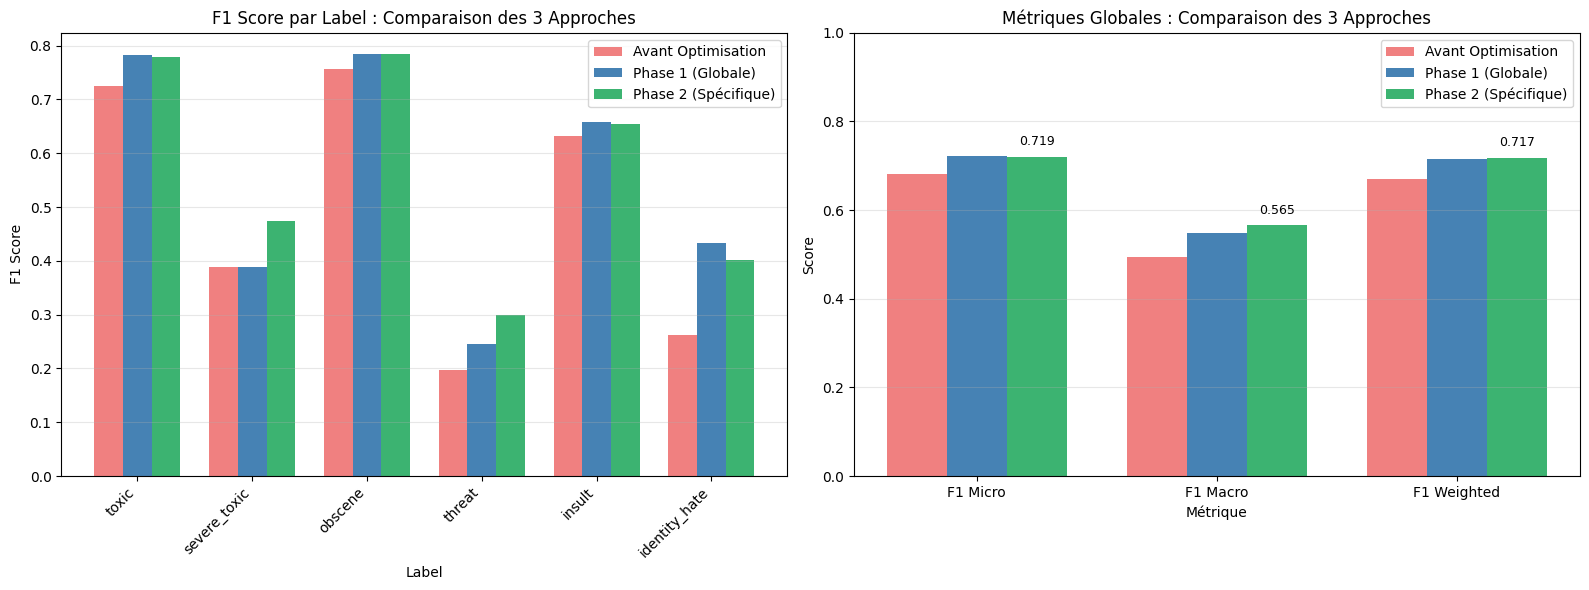

In [131]:
# Visualisation finale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: F1 par label pour les 3 approches
x = np.arange(len(label_cols))
width = 0.25

bars1 = axes[0].bar(x - width, comparison_df_final['Avant Opt'], width, label='Avant Optimisation', color='lightcoral')
bars2 = axes[0].bar(x, comparison_df_final['Phase 1 (Global)'], width, label='Phase 1 (Globale)', color='steelblue')
bars3 = axes[0].bar(x + width, comparison_df_final['Phase 2 (Spécifique)'], width, label='Phase 2 (Spécifique)', color='mediumseagreen')

axes[0].set_xlabel('Label')
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score par Label : Comparaison des 3 Approches')
axes[0].set_xticks(x)
axes[0].set_xticklabels(label_cols, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: Métriques globales
metrics = ['F1 Micro', 'F1 Macro', 'F1 Weighted']
avant_vals = [
    f1_score(y_test, ensemble_predictions, average='micro'),
    f1_score(y_test, ensemble_predictions, average='macro'),
    f1_score(y_test, ensemble_predictions, average='weighted')
]
phase1_vals = [
    f1_score(y_test, ensemble_opt_predictions, average='micro'),
    f1_score(y_test, ensemble_opt_predictions, average='macro'),
    f1_score(y_test, ensemble_opt_predictions, average='weighted')
]
phase2_vals = [
    f1_score(y_test, phase2_ensemble_predictions, average='micro'),
    f1_score(y_test, phase2_ensemble_predictions, average='macro'),
    f1_score(y_test, phase2_ensemble_predictions, average='weighted')
]

x2 = np.arange(len(metrics))
bars1 = axes[1].bar(x2 - width, avant_vals, width, label='Avant Optimisation', color='lightcoral')
bars2 = axes[1].bar(x2, phase1_vals, width, label='Phase 1 (Globale)', color='steelblue')
bars3 = axes[1].bar(x2 + width, phase2_vals, width, label='Phase 2 (Spécifique)', color='mediumseagreen')

axes[1].set_xlabel('Métrique')
axes[1].set_ylabel('Score')
axes[1].set_title('Métriques Globales : Comparaison des 3 Approches')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Ajouter les valeurs sur les barres
for bar, val in zip(bars3, phase2_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [132]:
# Résumé des paramètres optimisés par label (Phase 2)
print("="*80)
print("RÉSUMÉ : PARAMÈTRES OPTIMISÉS PAR LABEL (PHASE 2)")
print("="*80)

for label in label_cols:
    info = best_models_per_label_phase2[label]
    print(f"\n📌 {label.upper()}")
    print(f"   Modèle: {info['model_name']}")
    print(f"   Score CV: {info['cv_score']:.4f}")
    print(f"   Paramètres:")
    for param, value in info['params'].items():
        print(f"      {param}: {value}")

RÉSUMÉ : PARAMÈTRES OPTIMISÉS PAR LABEL (PHASE 2)

📌 TOXIC
   Modèle: Logistic Regression
   Score CV: 0.7641
   Paramètres:
      clf__estimator__C: 10.0
      clf__estimator__solver: lbfgs
      tfidf__max_df: 0.5
      tfidf__min_df: 5
      tfidf__ngram_range: (1, 1)

📌 SEVERE_TOXIC
   Modèle: Naive Bayes
   Score CV: 0.4497
   Paramètres:
      clf__estimator__alpha: 0.01
      tfidf__max_df: 0.5
      tfidf__min_df: 3
      tfidf__ngram_range: (1, 2)

📌 OBSCENE
   Modèle: Logistic Regression
   Score CV: 0.7751
   Paramètres:
      clf__estimator__C: 10.0
      clf__estimator__solver: lbfgs
      tfidf__max_df: 0.5
      tfidf__min_df: 3
      tfidf__ngram_range: (1, 1)

📌 THREAT
   Modèle: Logistic Regression
   Score CV: 0.4208
   Paramètres:
      clf__estimator__C: 10.0
      clf__estimator__solver: lbfgs
      tfidf__max_df: 0.5
      tfidf__min_df: 3
      tfidf__ngram_range: (1, 1)

📌 INSULT
   Modèle: Logistic Regression
   Score CV: 0.6678
   Paramètres:
      clf__estim

In [133]:
# Comparaison finale : Ensemble avant vs après optimisation
print("="*80)
print("COMPARAISON FINALE : ENSEMBLE AVANT vs APRÈS OPTIMISATION")
print("="*80)

# Métriques ensemble avant (avec modèles non-optimisés)
ensemble_avant_metrics = {
    'Hamming Loss': hamming_loss(y_test, ensemble_predictions),
    'Jaccard Score': jaccard_score(y_test, ensemble_predictions, average='samples'),
    'F1 Micro': f1_score(y_test, ensemble_predictions, average='micro'),
    'F1 Macro': f1_score(y_test, ensemble_predictions, average='macro'),
    'F1 Weighted': f1_score(y_test, ensemble_predictions, average='weighted')
}

# Métriques ensemble après (avec modèles optimisés)
ensemble_apres_metrics = {
    'Hamming Loss': hamming_loss(y_test, ensemble_opt_predictions),
    'Jaccard Score': jaccard_score(y_test, ensemble_opt_predictions, average='samples'),
    'F1 Micro': f1_score(y_test, ensemble_opt_predictions, average='micro'),
    'F1 Macro': f1_score(y_test, ensemble_opt_predictions, average='macro'),
    'F1 Weighted': f1_score(y_test, ensemble_opt_predictions, average='weighted')
}

print(f"\n{'Métrique':<15} {'Ensemble AVANT':<18} {'Ensemble APRÈS':<18} {'Δ':<12} {'Amélioration'}")
print("-"*75)

for metric in ['F1 Micro', 'F1 Macro', 'F1 Weighted', 'Jaccard Score', 'Hamming Loss']:
    avant = ensemble_avant_metrics[metric]
    apres = ensemble_apres_metrics[metric]
    delta = apres - avant
    
    # Pour Hamming Loss, une diminution est une amélioration
    if metric == 'Hamming Loss':
        pct = (-delta / avant) * 100 if avant != 0 else 0
        status = f"✅ -{abs(pct):.2f}%" if delta < 0 else f"❌ +{pct:.2f}%" if delta > 0 else "➖"
    else:
        pct = (delta / avant) * 100 if avant != 0 else 0
        status = f"✅ +{pct:.2f}%" if delta > 0 else f"❌ {pct:.2f}%" if delta < 0 else "➖"
    
    print(f"{metric:<15} {avant:<18.4f} {apres:<18.4f} {delta:<+12.4f} {status}")

# Tableau récapitulatif final
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF FINAL")
print("="*80)

final_comparison = pd.DataFrame({
    'Modèle': ['Ensemble (Non-Optimisé)', 'Ensemble (Optimisé)', 'Logistic Regression (Optimisé)'],
    'F1 Micro': [
        f1_score(y_test, ensemble_predictions, average='micro'),
        f1_score(y_test, ensemble_opt_predictions, average='micro'),
        f1_score(y_test, lr_opt_predictions, average='micro')
    ],
    'F1 Macro': [
        f1_score(y_test, ensemble_predictions, average='macro'),
        f1_score(y_test, ensemble_opt_predictions, average='macro'),
        f1_score(y_test, lr_opt_predictions, average='macro')
    ],
    'F1 Weighted': [
        f1_score(y_test, ensemble_predictions, average='weighted'),
        f1_score(y_test, ensemble_opt_predictions, average='weighted'),
        f1_score(y_test, lr_opt_predictions, average='weighted')
    ]
})

print(final_comparison.to_string(index=False))

COMPARAISON FINALE : ENSEMBLE AVANT vs APRÈS OPTIMISATION

Métrique        Ensemble AVANT     Ensemble APRÈS     Δ            Amélioration
---------------------------------------------------------------------------
F1 Micro        0.6812             0.7227             +0.0415      ✅ +6.09%
F1 Macro        0.4939             0.5486             +0.0547      ✅ +11.07%
F1 Weighted     0.6712             0.7158             +0.0445      ✅ +6.63%
Jaccard Score   0.0477             0.0514             +0.0038      ✅ +7.89%
Hamming Loss    0.0202             0.0179             -0.0023      ✅ -11.44%

TABLEAU RÉCAPITULATIF FINAL
                        Modèle  F1 Micro  F1 Macro  F1 Weighted
       Ensemble (Non-Optimisé)  0.681212  0.493925     0.671236
           Ensemble (Optimisé)  0.722685  0.548623     0.715759
Logistic Regression (Optimisé)  0.720975  0.543746     0.714469


## 8. Ensemble Hybride

In [143]:
# PHASE 3 : Ensemble Hybride - Meilleur de Phase 1 ou Phase 2 par label
print("="*80)
print("PHASE 3 : ENSEMBLE HYBRIDE (Meilleur de Phase 1 ou Phase 2 par label)")
print("="*80)

# Comparer Phase 1 vs Phase 2 pour chaque label
best_phase_per_label = {}
hybrid_predictions = []

for label in label_cols:
    label_idx = label_cols.index(label)
    
    # F1 Phase 1
    f1_p1 = f1_score(y_test.iloc[:, label_idx], ensemble_opt_predictions[:, label_idx])
    
    # F1 Phase 2
    f1_p2 = f1_score(y_test.iloc[:, label_idx], phase2_predictions_per_label[label])
    
    # Choisir le meilleur
    if f1_p1 >= f1_p2:
        best_phase_per_label[label] = {'phase': 'Phase 1', 'f1': f1_p1}
        hybrid_predictions.append(ensemble_opt_predictions[:, label_idx])
    else:
        best_phase_per_label[label] = {'phase': 'Phase 2', 'f1': f1_p2}
        hybrid_predictions.append(phase2_predictions_per_label[label])

# Créer la matrice de prédictions hybride
hybrid_ensemble_predictions = np.column_stack(hybrid_predictions)

# Afficher le choix par label
print("\n Meilleure phase par label:")
for label, info in best_phase_per_label.items():
    print(f"   {label:15s} → {info['phase']} (F1 = {info['f1']:.4f})")

# Métriques de l'ensemble hybride
print("\n" + "="*60)
print("MÉTRIQUES DE L'ENSEMBLE HYBRIDE")
print("="*60)
print(f"F1 Micro:    {f1_score(y_test, hybrid_ensemble_predictions, average='micro'):.4f}")
print(f"F1 Macro:    {f1_score(y_test, hybrid_ensemble_predictions, average='macro'):.4f}")
print(f"F1 Weighted: {f1_score(y_test, hybrid_ensemble_predictions, average='weighted'):.4f}")
print(f"Hamming Loss: {hamming_loss(y_test, hybrid_ensemble_predictions):.4f}")

# Comparaison finale avec toutes les approches
print("\n" + "="*80)
print("COMPARAISON FINALE COMPLÈTE")
print("="*80)

all_approaches = {
    'Avant Optimisation': ensemble_predictions,
    'Phase 1 (Opt Globale)': ensemble_opt_predictions,
    'Phase 2 (Opt Spécifique)': phase2_ensemble_predictions,
    'Phase 3 (Hybride)': hybrid_ensemble_predictions
}

print(f"\n{'Approche':<25} {'F1 Micro':<12} {'F1 Macro':<12} {'F1 Weighted':<12}")
print("-"*65)

for name, preds in all_approaches.items():
    f1_micro = f1_score(y_test, preds, average='micro')
    f1_macro = f1_score(y_test, preds, average='macro')
    f1_weighted = f1_score(y_test, preds, average='weighted')
    print(f"{name:<25} {f1_micro:<12.4f} {f1_macro:<12.4f} {f1_weighted:<12.4f}")


PHASE 3 : ENSEMBLE HYBRIDE (Meilleur de Phase 1 ou Phase 2 par label)

 Meilleure phase par label:
   toxic           → Phase 1 (F1 = 0.7825)
   severe_toxic    → Phase 2 (F1 = 0.4738)
   obscene         → Phase 1 (F1 = 0.7847)
   threat          → Phase 2 (F1 = 0.2985)
   insult          → Phase 1 (F1 = 0.6573)
   identity_hate   → Phase 1 (F1 = 0.4323)

MÉTRIQUES DE L'ENSEMBLE HYBRIDE
F1 Micro:    0.7218
F1 Macro:    0.5715
F1 Weighted: 0.7202
Hamming Loss: 0.0183

COMPARAISON FINALE COMPLÈTE

Approche                  F1 Micro     F1 Macro     F1 Weighted 
-----------------------------------------------------------------
Avant Optimisation        0.6812       0.4939       0.6712      
Phase 1 (Opt Globale)     0.7227       0.5486       0.7158      
Phase 2 (Opt Spécifique)  0.7191       0.5654       0.7169      
Phase 3 (Hybride)         0.7218       0.5715       0.7202      


## 9. Test sur des Exemples Personnalisés

In [144]:
# Fonction de prédiction avec l'ensemble hybride
def predict_toxicity_hybrid(text, best_phase_per_label, 
                            models_phase1, best_models_phase2, label_cols):
    """
    Prédit les labels de toxicité avec l'ensemble hybride.
    """
    text_processed = preprocess_text(text, remove_stopwords=False, normalize=None)
    
    print(f"\nTexte: {text}")
    print(f"\nPrédictions (Ensemble Hybride):")
    
    predictions = []
    for label in label_cols:
        label_idx = label_cols.index(label)
        phase = best_phase_per_label[label]['phase']
        
        if phase == 'Phase 1':
            # Utiliser le modèle optimisé globalement
            model_name = best_model_per_label_opt[label]
            model = models_phase1[model_name]
        else:
            # Utiliser le modèle optimisé spécifiquement
            model = best_models_per_label_phase2[label]['model']
        
        pred = model.predict([text_processed])[0]
        pred_value = pred[label_idx]
        predictions.append(pred_value)
        
        status = "✓" if pred_value == 1 else "✗"
        print(f"  {status} {label:15s}: {pred_value} ({phase})")
    
    return predictions

# Modèles Phase 1 optimisés
models_phase1 = {
    'Naive Bayes': nb_best_model,
    'Logistic Regression': lr_best_model,
    'Random Forest': rf_best_model
}


In [145]:
# Tester sur des exemples
test_texts = [
    "You are stupid!",
    "I really appreciate your help, thank you!",
    "This is absolutely ridiculous and you should be ashamed!",
    "I disagree with your point, but I respect your opinion.",
    "Go to hell you idiot!"
]

for text in test_texts:
    predict_toxicity_hybrid(text, best_phase_per_label, 
                           models_phase1, best_models_per_label_phase2, label_cols)
    print("\n" + "="*60)



Texte: You are stupid!

Prédictions (Ensemble Hybride):
  ✓ toxic          : 1 (Phase 1)
  ✗ severe_toxic   : 0 (Phase 2)
  ✓ obscene        : 1 (Phase 1)
  ✗ threat         : 0 (Phase 2)
  ✓ insult         : 1 (Phase 1)
  ✗ identity_hate  : 0 (Phase 1)


Texte: I really appreciate your help, thank you!

Prédictions (Ensemble Hybride):
  ✗ toxic          : 0 (Phase 1)
  ✗ severe_toxic   : 0 (Phase 2)
  ✗ obscene        : 0 (Phase 1)
  ✗ threat         : 0 (Phase 2)
  ✗ insult         : 0 (Phase 1)
  ✗ identity_hate  : 0 (Phase 1)


Texte: This is absolutely ridiculous and you should be ashamed!

Prédictions (Ensemble Hybride):
  ✓ toxic          : 1 (Phase 1)
  ✗ severe_toxic   : 0 (Phase 2)
  ✗ obscene        : 0 (Phase 1)
  ✗ threat         : 0 (Phase 2)
  ✗ insult         : 0 (Phase 1)
  ✗ identity_hate  : 0 (Phase 1)


Texte: I disagree with your point, but I respect your opinion.

Prédictions (Ensemble Hybride):
  ✗ toxic          : 0 (Phase 1)
  ✗ severe_toxic   : 0 (Phase 2)
  

## 10. Sauvegarde du Modèle Final

In [146]:
import pickle

class ToxicityClassifier:
    def __init__(self, best_phase_per_label, models_phase1, 
                 best_model_per_label_opt, best_models_per_label_phase2, label_cols):
        self.best_phase_per_label = best_phase_per_label
        self.models_phase1 = models_phase1
        self.best_model_per_label_opt = best_model_per_label_opt
        self.best_models_per_label_phase2 = best_models_per_label_phase2
        self.label_cols = label_cols
    
    def preprocess(self, text):
        """Preprocessing intégré à la classe"""
        from nltk.tokenize import word_tokenize
        text = str(text).lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.isalpha()]
        return ' '.join(tokens)
    
    def predict(self, text):
        """Prédit les labels de toxicité"""
        text_clean = self.preprocess(text)
        
        predictions = {}
        for label in self.label_cols:
            label_idx = self.label_cols.index(label)
            phase = self.best_phase_per_label[label]['phase']
            
            if phase == 'Phase 1':
                model_name = self.best_model_per_label_opt[label]
                model = self.models_phase1[model_name]
            else:
                model = self.best_models_per_label_phase2[label]['model']
            
            pred = model.predict([text_clean])[0][label_idx]
            predictions[label] = int(pred)
        
        return predictions
    
    def predict_proba(self, text):
        """Prédit les probabilités (si disponible)"""
        # À implémenter si besoin
        pass

# Créer et sauvegarder
classifier = ToxicityClassifier(
    best_phase_per_label=best_phase_per_label,
    models_phase1=models_phase1,
    best_model_per_label_opt=best_model_per_label_opt,
    best_models_per_label_phase2=best_models_per_label_phase2,
    label_cols=label_cols
)

with open('toxicity_classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

print("Classifier sauvegardé!")


Classifier sauvegardé!


## 11. Résumé Final

In [149]:
# Tableau récapitulatif final
print("="*80)
print("RÉSUMÉ FINAL DU PROJET")
print("="*80)

print("\n Performance des différentes approches:")
print("-"*65)
print(f"{'Approche':<30} {'F1 Micro':<12} {'F1 Macro':<12} {'F1 Weighted'}")
print("-"*65)

approaches = {
    'Modèles de Base (Ensemble)': ensemble_predictions,
    'Phase 1 - Opt Globale': ensemble_opt_predictions,
    'Phase 2 - Opt Spécifique': phase2_ensemble_predictions,
    'Phase 3 - Hybride (FINAL)': hybrid_ensemble_predictions
}

for name, preds in approaches.items():
    f1_mi = f1_score(y_test, preds, average='micro')
    f1_ma = f1_score(y_test, preds, average='macro')
    f1_we = f1_score(y_test, preds, average='weighted')
    print(f"{name:<30} {f1_mi:<12.4f} {f1_ma:<12.4f} {f1_we:.4f}")

print("\n Configuration finale de l'Ensemble Hybride:")
for label, info in best_phase_per_label.items():
    phase = info['phase']
    f1 = info['f1']
    if phase == 'Phase 1':
        model_name = best_model_per_label_opt[label]
    else:
        model_name = best_models_per_label_phase2[label]['model_name']
    print(f"   {label:15s} → {phase} ({model_name}) - F1: {f1:.4f}")


RÉSUMÉ FINAL DU PROJET

 Performance des différentes approches:
-----------------------------------------------------------------
Approche                       F1 Micro     F1 Macro     F1 Weighted
-----------------------------------------------------------------
Modèles de Base (Ensemble)     0.6812       0.4939       0.6712
Phase 1 - Opt Globale          0.7227       0.5486       0.7158
Phase 2 - Opt Spécifique       0.7191       0.5654       0.7169
Phase 3 - Hybride (FINAL)      0.7218       0.5715       0.7202

 Configuration finale de l'Ensemble Hybride:
   toxic           → Phase 1 (Logistic Regression) - F1: 0.7825
   severe_toxic    → Phase 2 (Naive Bayes) - F1: 0.4738
   obscene         → Phase 1 (Logistic Regression) - F1: 0.7847
   threat          → Phase 2 (Logistic Regression) - F1: 0.2985
   insult          → Phase 1 (Logistic Regression) - F1: 0.6573
   identity_hate   → Phase 1 (Logistic Regression) - F1: 0.4323


#### partie Comparaison avec d'autres modèles

In [1]:
# Comparaison : XGBoost vs Ensemble Hybride
print("="*80)
print("COMPARAISON DES 2 MODÈLES FINAUX")
print("="*80)

# 1. Charger le modèle XGBoost
import sys
sys.path.append('.')
from final_model import ToxicCommentClassifier

xgb_classifier = ToxicCommentClassifier.load('toxic_classifier.pkl')

# 2. Préparer les données de test (utiliser X_test existant)
# Le modèle XGBoost a son propre preprocessing, donc on utilise les textes bruts
# Récupérer les textes bruts correspondant à X_test
test_indices = X_test.index
X_test_raw = df.loc[test_indices, 'comment_text']

print(f"\nTaille du test set: {len(X_test_raw)} commentaires")


COMPARAISON DES 2 MODÈLES FINAUX

Chargement du modèle depuis toxic_classifier.pkl...
✓ Modèle chargé avec succès


NameError: name 'X_test' is not defined

In [ ]:
# 3. Prédictions avec XGBoost
print("\n" + "="*60)
print("Prédictions XGBoost en cours...")
print("="*60)

xgb_predictions_df = xgb_classifier.predict(X_test_raw.tolist())
xgb_predictions = xgb_predictions_df[label_cols].values

print("Prédictions XGBoost terminées!")



Prédictions XGBoost en cours...
Prédictions XGBoost terminées!


In [ ]:
# 4. Calculer les métriques pour les deux modèles
print("\n" + "="*80)
print("RÉSULTATS COMPARATIFS")
print("="*80)

from sklearn.metrics import f1_score, hamming_loss, jaccard_score

# Métriques XGBoost
xgb_metrics = {
    'F1 Micro': f1_score(y_test, xgb_predictions, average='micro'),
    'F1 Macro': f1_score(y_test, xgb_predictions, average='macro'),
    'F1 Weighted': f1_score(y_test, xgb_predictions, average='weighted'),
    'Hamming Loss': hamming_loss(y_test, xgb_predictions),
    'Jaccard Score': jaccard_score(y_test, xgb_predictions, average='samples')
}

# Métriques Ensemble Hybride (déjà calculées)
hybrid_metrics = {
    'F1 Micro': f1_score(y_test, hybrid_ensemble_predictions, average='micro'),
    'F1 Macro': f1_score(y_test, hybrid_ensemble_predictions, average='macro'),
    'F1 Weighted': f1_score(y_test, hybrid_ensemble_predictions, average='weighted'),
    'Hamming Loss': hamming_loss(y_test, hybrid_ensemble_predictions),
    'Jaccard Score': jaccard_score(y_test, hybrid_ensemble_predictions, average='samples')
}

# Afficher le tableau comparatif
print(f"\n{'Métrique':<15} {'XGBoost':<12} {'Hybride NB/LR/RF':<18} {'Meilleur'}")
print("-"*60)

for metric in ['F1 Micro', 'F1 Macro', 'F1 Weighted', 'Jaccard Score', 'Hamming Loss']:
    xgb_val = xgb_metrics[metric]
    hyb_val = hybrid_metrics[metric]
    
    # Pour Hamming Loss, plus petit = mieux
    if metric == 'Hamming Loss':
        winner = "XGBoost" if xgb_val < hyb_val else "Hybride" if hyb_val < xgb_val else "Égalité"
    else:
        winner = "XGBoost" if xgb_val > hyb_val else "Hybride" if hyb_val > xgb_val else "Égalité"
    
    print(f"{metric:<15} {xgb_val:<12.4f} {hyb_val:<18.4f} {winner}")



RÉSULTATS COMPARATIFS

Métrique        XGBoost      Hybride NB/LR/RF   Meilleur
------------------------------------------------------------
F1 Micro        0.7057       0.7218             Hybride
F1 Macro        0.6755       0.5715             XGBoost
F1 Weighted     0.7170       0.7202             Hybride
Jaccard Score   0.0744       0.0510             XGBoost
Hamming Loss    0.0265       0.0183             Hybride


In [ ]:
# 5. Comparaison par label
print("\n" + "="*80)
print("F1 SCORE PAR LABEL")
print("="*80)

print(f"\n{'Label':<15} {'XGBoost':<12} {'Hybride':<12} {'Δ':<10} {'Meilleur'}")
print("-"*55)

for i, label in enumerate(label_cols):
    xgb_f1 = f1_score(y_test.iloc[:, i], xgb_predictions[:, i])
    hyb_f1 = f1_score(y_test.iloc[:, i], hybrid_ensemble_predictions[:, i])
    delta = xgb_f1 - hyb_f1
    winner = "XGBoost" if delta > 0 else "Hybride" if delta < 0 else "Égalité"
    
    print(f"{label:<15} {xgb_f1:<12.4f} {hyb_f1:<12.4f} {delta:<+10.4f} {winner}")



F1 SCORE PAR LABEL

Label           XGBoost      Hybride      Δ          Meilleur
-------------------------------------------------------
toxic           0.6521       0.7825       -0.1304    Hybride
severe_toxic    0.5534       0.4738       +0.0795    XGBoost
obscene         0.8385       0.7847       +0.0538    XGBoost
threat          0.6000       0.2985       +0.3015    XGBoost
insult          0.7633       0.6573       +0.1061    XGBoost
identity_hate   0.6455       0.4323       +0.2132    XGBoost


In [ ]:
# 7. Conclusion
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

# Compter les victoires par label
xgb_wins = sum(1 for i in range(len(label_cols)) 
               if f1_score(y_test.iloc[:, i], xgb_predictions[:, i]) > 
                  f1_score(y_test.iloc[:, i], hybrid_ensemble_predictions[:, i]))

hyb_wins = len(label_cols) - xgb_wins

print(f"\nVictoires par label: XGBoost {xgb_wins} - Hybride {hyb_wins}")

if xgb_metrics['F1 Macro'] > hybrid_metrics['F1 Macro']:
    print(f"\n�� GAGNANT GLOBAL: XGBoost")
    print(f"   F1 Macro: {xgb_metrics['F1 Macro']:.4f} vs {hybrid_metrics['F1 Macro']:.4f}")
else:
    print(f"\n🏆 GAGNANT GLOBAL: Ensemble Hybride (NB/LR/RF)")
    print(f"   F1 Macro: {hybrid_metrics['F1 Macro']:.4f} vs {xgb_metrics['F1 Macro']:.4f}")



CONCLUSION

Victoires par label: XGBoost 5 - Hybride 1

�� GAGNANT GLOBAL: XGBoost
   F1 Macro: 0.6755 vs 0.5715
